# Визуализация данных

Датасет - данные о продажах тонометров в России за 2010-2011 годы.

In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
from pylab import rcParams



In [2]:
data = pd.read_excel('BPM_2010_2011.xlsx')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101525 entries, 0 to 101524
Data columns (total 12 columns):
Region            101525 non-null object
Month             101525 non-null int64
Year              101525 non-null int64
SKU               101525 non-null object
Producer          101525 non-null object
Type              101525 non-null object
Sell_in_price     101525 non-null float64
Sell_in_pcs       101525 non-null int64
Sell_in_rur       101525 non-null int64
Sell_out_price    101525 non-null float64
Sell_out_rur      101525 non-null int64
Distribution      101525 non-null float64
dtypes: float64(3), int64(5), object(4)
memory usage: 9.3+ MB


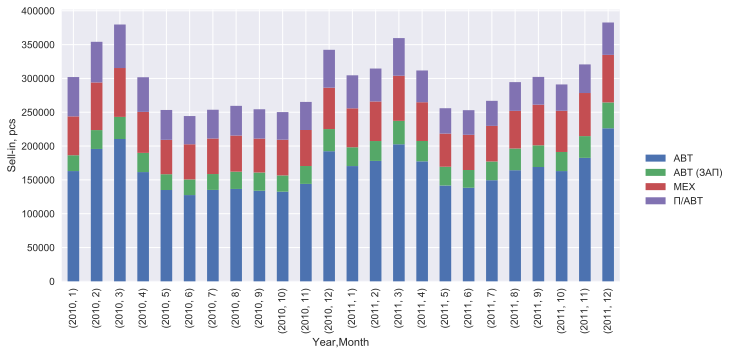

In [4]:
# Динамика рынка в штуках по категориям помесячно за 2 года. Используем  Sell_in_pcs - объем продаж в штуках.
# Сгруппируем по типам тонометров. Можно оценить соотношение категория и общие тенденции рынка.

%config InlineBackend.figure_format = 'svg' 
rcParams['figure.figsize'] = 10, 5
bar_plot = data.groupby(['Year', 'Month','Type'])['Sell_in_pcs']\
    .sum()\
    .unstack()\
    .plot(kind = 'bar', stacked =True)
    
bar_plot.legend(bbox_to_anchor=(1.2, 0.5))
bar_plot.set_ylabel('Sell-in, pcs')
    

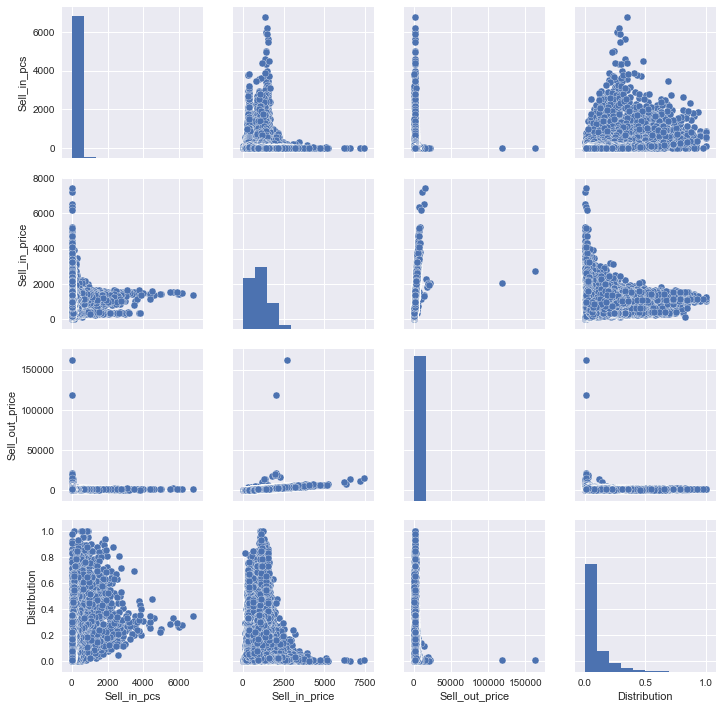

In [10]:
#Оценка зависимости продаж от цены и дистрибуции

%config InlineBackend.figure_format = 'png' 

pairplot = sns.pairplot(data[['Sell_in_pcs', 
                              'Sell_in_price', 
                              'Sell_out_price',
                              'Distribution']])

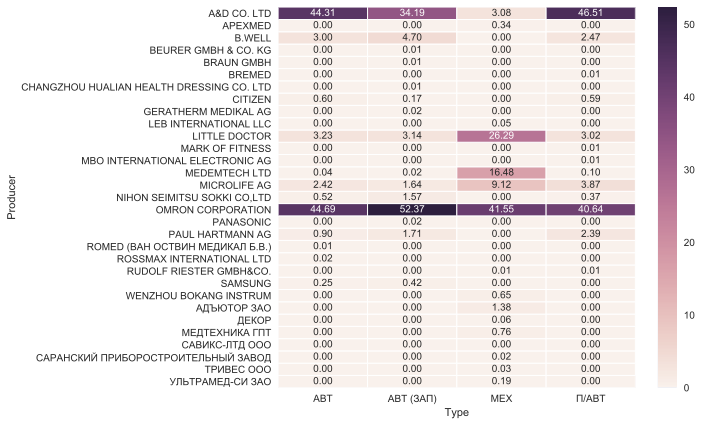

In [5]:
# Доля рынка, занимаемая производителями в различных категориях (в штуках), суммарно за два года.
# Позволяет легко определеить наиболее крупных игроков на рынке.

%config InlineBackend.figure_format = 'svg' 
rcParams['figure.figsize'] = 8, 7

producer_type_sell_in = data.pivot_table(index='Producer',
                                       columns = 'Type', 
                                       values = 'Sell_in_pcs',
                                       aggfunc=sum)\
                            .fillna(0)\
                            .applymap(float)\
                            .apply(lambda x: 100*x/x.sum())

sns.heatmap(producer_type_sell_in, annot=True, fmt=".2f", linewidths=1.0)

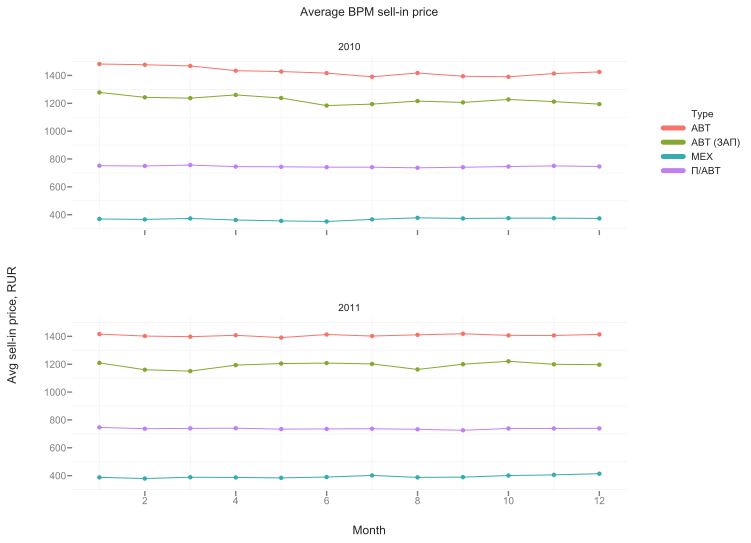

<ggplot: (287105600)>


In [8]:
# Динамика средней цены (Sell_in_price) BPM по месяцам и типам.
# Оцениваем присутствие сезонности и трендов, а также ценового позиционирования категорий.

import ggplot

facet = data.groupby(['Year',
                      'Month',
                      'Type'], as_index=False)[['Sell_in_price']].mean()

p = ggplot.ggplot(facet, ggplot.aes(x = 'Month', y = 'Sell_in_price', color = 'Type') ) \
        + ggplot.geom_point() \
        + ggplot.geom_line() \
        + ggplot.xlab('Month') \
        + ggplot.ylab('Avg sell-in price, RUR') \
        + ggplot.ggtitle('Average BPM sell-in price') \
        + ggplot.facet_wrap('Year')\
        + ggplot.theme_bw()
print(p);

In [7]:
# Продажи (в рублях, Sell_in_rur) топ-5 производителей (по объему продаж в шт) с т.з. продаж в шт и уровня дистрибуции
# Позволяет сделать вывод об олигополии на рынке и оценить соотношение между крупнейшими игроками.

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

top5 = data.groupby(['Producer'], as_index = False)[['Producer','Sell_in_pcs']]\
        .sum()\
        .sort_values(by = 'Sell_in_pcs', ascending = False)\
        .head()

bubble_data = data.loc[(data['Producer'].isin(list(top5['Producer'])))]\
                  .groupby(['Producer'], as_index = True)\
                  .agg({'Sell_in_pcs':'sum','Sell_in_rur':'sum','Distribution':'mean'})

trace0 = go.Scatter(
    x=bubble_data['Sell_in_pcs'],
    y=bubble_data['Distribution'],
    mode = 'markers+text',
    text = bubble_data.index,
    textposition='bottom',
    marker = dict(
        size = 1/15000000*bubble_data.Sell_in_rur,
        color = [
            'aqua', 'blue', 'green',
            'red', 'pink'
        ]
    )
)

data_plot = [trace0]
layout = {
    'title': 'Top5 producers',
    'xaxis': {'title': 'Sell-in, pcs'},
    'yaxis': {'title': 'Avg distribution'}
}

fig = go.Figure(data=data_plot, layout=layout)

iplot(fig, show_link=False)
